# Popular Data Science Questions #

Our goal in this project is to use [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine what content should a data science education company create, based on interest by subject.

## Stack Exhange ##

**What kind of questions are welcomed to this site?**

On DSSE's help center's [section on questions](https://datascience.stackexchange.com/help/asking), we can read that we should:

- Avoid subjective questions.
- Ask practical questions about Data Science - there are adequate sites for practical questions.
- Ask specific questions.
- Make questions relevant to others.

All of these characteristics, if employed, should be helpful attributes to our goal.

In the help center , we also learned that in addition to the sites mentioned in the Learn section, there are two sites that are relevant:

- [Open Data](https://opendata.stackexchange.com/help/on-topic) (Dataset requests)
- [Computational Science](https://scicomp.stackexchange.com/help/on-topic) (Software packages and algorithms in applied mathematics)

**What, other than questions, does this site's home subdivide into?**

On the [home page](https://datascience.stackexchange.com/), we have four sections:

- [Questions](https://datascience.stackexchange.com/questions) - a list of questions asked;
- [Tags](https://datascience.stackexchange.com/tags) -  a list of tags (keywords or labels that categorize questions);
- [Users](https://datascience.stackexchange.com/users) - a list of users;
- [Unaswered](https://datascience.stackexchange.com/unanswered) - a list of unanswered questions;

The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allows us to quantify how many questions are asked about subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heeavily moderated by the community; this gives us more confidence in using the tagging system to derive conclusions.  

**What information is available in each post?**

Some of the information we see is:

- For both questions and answers:
    - The post's score;
    - The post's title;
    - The post's author;
    - The post's body;
- For questions only:
    - The last time the question as active;
    - How many times the question was viewed;
    - Related questions;
    - The question's tags;    

## Stack Exchange Data Explorer ##

Perusing the table names, a few stand out as relevant to our goal:

- Posts
- PostTags
- Tags
- TagsSynonyms

Running a few exploratory queries, leads us to foucus our efforts on `Posts` table. For example, The `Tags` table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

## Getting the Data ##

To get the relevant data we run the following query.

SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM Posts
WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;

## Exploring the Data ##

We can read in the data while immediately making sure `CreationDate` will be stored as a datetime object:

In [1]:
import pandas as pd

questions = pd.read_csv("/Users/jay/Documents/2019_questions.csv", parse_dates=['CreationDate'])

In [2]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6757 entries, 0 to 6756
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             6757 non-null   int64         
 1   CreationDate   6757 non-null   datetime64[ns]
 2   Score          6757 non-null   int64         
 3   ViewCount      6757 non-null   int64         
 4   Tags           6757 non-null   object        
 5   AnswerCount    6757 non-null   int64         
 6   FavoriteCount  1759 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 369.6+ KB


We see that only `FavouriteCount` has missing values. A missing value on this column means that the question was not present in any users' favourite list, so we can replace missing values with zero.

The type seems adequate for every column, however, after we fill in the missing values on `FavouriteCount`, ther is no reason to store the values as floasts.

Since the `object` dtype is a catch-all type, let's see what types the objects in questions['Tags'] are.

In [3]:
questions['Tags'].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

We see that every value in the column is a string. On Stack Exchange, each question can only have a maximum of five tag([source](https://meta.stackexchange.com/a/18879)), so one way to deal with this is to create five columns in `quesitons` called `Tag1`, `Tag2`, `Tag3`, `Tag4`, `Tag5` and populate the columns with the tags in each row.

However, since this doesn't help in relating tags from one question to another, we'll keep them as a list.

## Cleaning the Data ##

We'll begin by fixing `FavortieCount`.

In [4]:
questions.fillna(value = {'FavoriteCount': 0}, inplace=True)
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

In [5]:
questions['Tags'] = questions['Tags'].str.replace("^<|>$", "").str.split("><")
questions.sample(3)

/var/folders/b3/lhqcwxhj01zg5g8dk4qjg3bw0000gn/T/ipykernel_3555/3912256704.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  questions['Tags'] = questions['Tags'].str.replace("^<|>$", "").str.split("><")


,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
4334,48543,2019-04-03 17:06:38,1,50,"[machine-learning, implementation, lasso]",0,0
6463,56054,2019-07-20 08:58:49,1,46,"[classification, data-mining]",0,0
774,60258,2019-09-16 06:52:32,0,221,"[deep-learning, nlp, machine-translation, tran...",1,0


## Most Used and Most Viewed ##

We'll begin by counting how many times each tag was used

In [6]:
tag_count = dict()

for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

For improved aesthetics, let's transform `tag_count` in a dataframe.

In [7]:
tag_count = pd.DataFrame.from_dict(tag_count, orient = 'index')
tag_count.rename(columns = {0: 'Count'}, inplace = True)
tag_count.head(10)

,Count
svm,102
multilabel-classification,70
machine-learning,2128
keras,706
reinforcement-learning,144
randomized-algorithms,6
data-mining,172
data-cleaning,118
outlier,47
neural-network,818


Let's now sort this dataframe by `Count` and visualize the top 20 results.


In [8]:
most_used = tag_count.sort_values(by = 'Count').tail(20)
most_used

,Count
machine-learning-model,172
feature-selection,175
r,194
predictive-modeling,211
clustering,229
dataset,248
regression,270
lstm,288
pandas,315
time-series,334


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:>

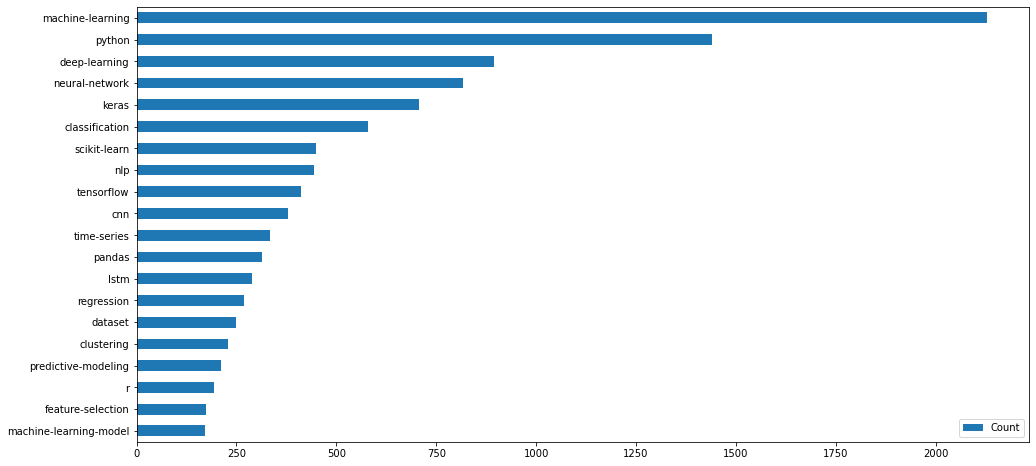

In [10]:
most_used.plot(kind = 'barh', figsize = (16,8))

Some tags are very, very broad and are unlikely to be useful; e.g.: `python`, `dataset`, `r`. Before we investigate the tags a little deeper, let's repeat the same process for views.

We'll use pandas'as pandas.DataFrame.iterrows().

<AxesSubplot:>

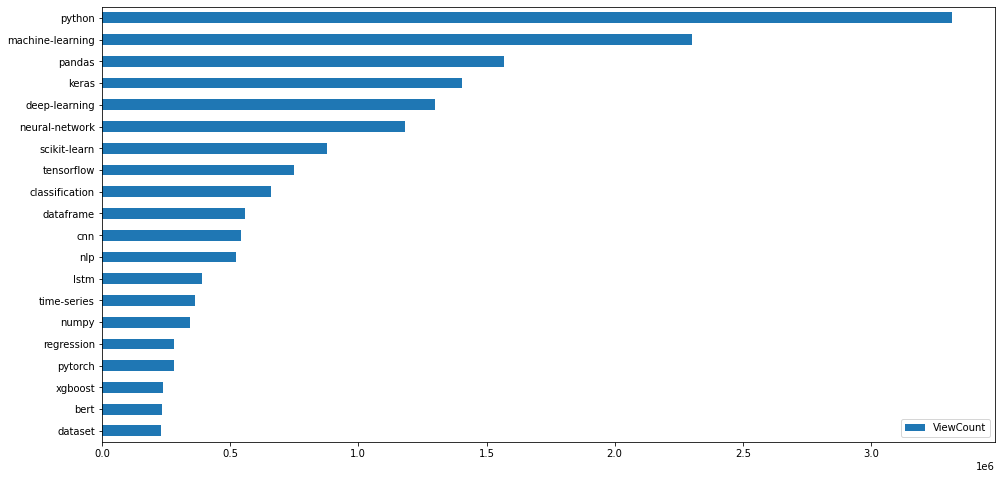

In [11]:
tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']

tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient='index')
tag_view_count.rename(columns={0: 'ViewCount'}, inplace= True)

most_viewed = tag_view_count.sort_values(by = 'ViewCount').tail(20)

most_viewed.plot(kind = 'barh', figsize = (16,8))

Let's see them side by side.

array([<AxesSubplot:title={'center':'ViewCount'}>], dtype=object)

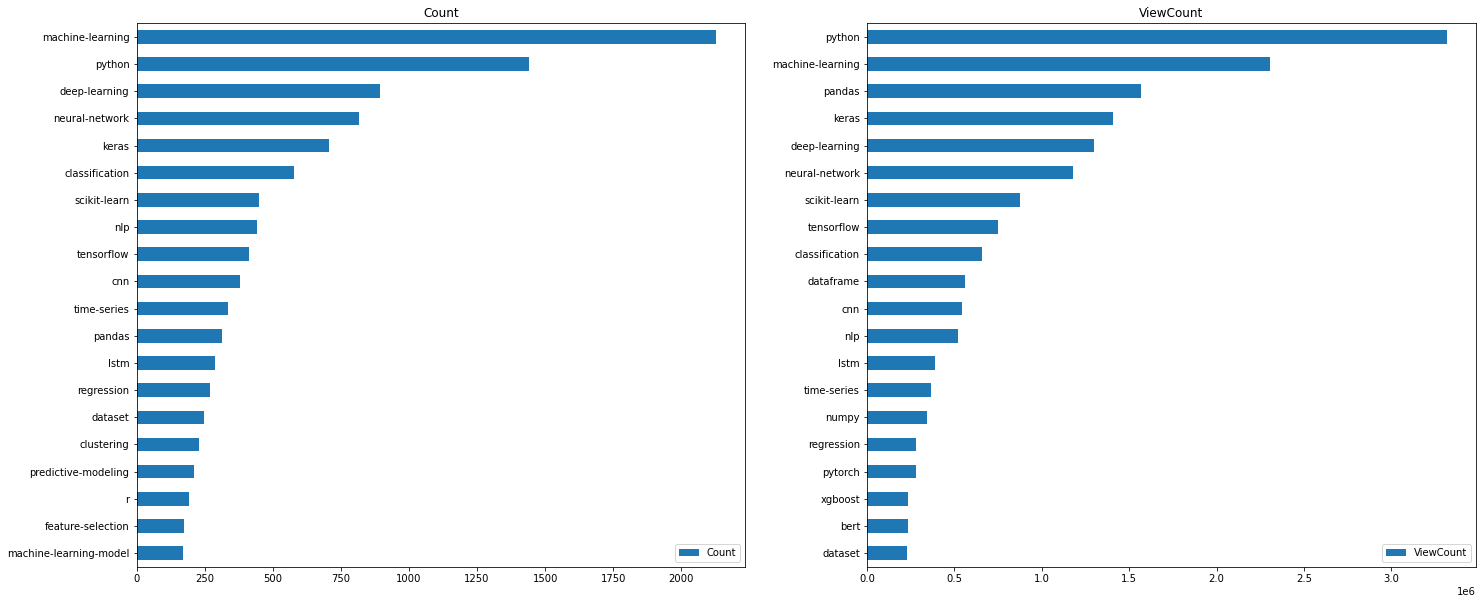

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind = 'barh', ax = axes[0], subplots = True)
most_viewed.plot(kind='barh', ax = axes[1], subplots = True)

Let's see what tags are in `most used` but not in `most_viewed`. We can identify them by the missing values in `ViewCount` below.

In [13]:
in_used = pd.merge(most_used, most_viewed, how = 'left', left_index= True, right_index= True)
in_used

,Count,ViewCount
machine-learning-model,172,NaN
feature-selection,175,NaN
r,194,NaN
predictive-modeling,211,NaN
clustering,229,NaN
dataset,248,230764.0
regression,270,282794.0
lstm,288,390546.0
pandas,315,1569394.0
time-series,334,364193.0


Similarly, let's see what tags are in the latter, but not in the former:

In [14]:
in_viewed = pd.merge(most_used, most_viewed, how = 'right', left_index = True, right_index = True)
in_viewed

,Count,ViewCount
dataset,248.0,230764
bert,NaN,233334
xgboost,NaN,236599
pytorch,NaN,281456
regression,270.0,282794
numpy,NaN,341978
time-series,334.0,364193
lstm,288.0,390546
nlp,443.0,521784
cnn,378.0,542206


The tags present in `most_used` but not in `most_viewed` are:

- `machine-learning-model`
- `feature-selection`
- `r`
- `predictive-modeling`

And the tags present in `most_viewed` but not in `most_used` are:

- `bert`
- `xgboost`
- `pytorch`
- `numpy`
- `dataframe`

## Relations Between Tags ##

One way of trying to gauge how pairs of tags are related to each other, is to count how many times each pair appears together. Let's do this.

We'll begin by creating a list of all tags.

In [15]:
all_tags = list(tag_count.index)

We'll now create a dataframe where each row will represent a tag, and each column as well.

In [16]:
associations = pd.DataFrame(index = all_tags, columns = all_tags)
associations.head(4)

,svm,multilabel-classification,machine-learning,keras,reinforcement-learning,randomized-algorithms,data-mining,data-cleaning,outlier,neural-network,...,meta-learning,community,software-development,caffe,word,feature-map,movielens,momentum,allennlp,manifold
svm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
multilabel-classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
machine-learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
keras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll now fill this dataframe with zeroes and then, for each lists of tags in `questions['tags']`, we will increment the intervening tags by one. The end result will be a dataframe that for each pair of tags, it tells us how many times they were used togther.

In [17]:
associations.fillna(0, inplace = True)

for tags in questions['Tags']:
    associations.loc[tags, tags] += 1

This datframe is quite large. Let's focus our attention on the most used tags. We'll add some colors to make it easier to talk about the datframe.

In [18]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,feature-selection,r,predictive-modeling,clustering,dataset,regression,lstm,pandas,time-series,cnn,tensorflow,nlp,scikit-learn,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,172,7,5,17,3,10,5,3,1,5,3,6,5,15,21,12,8,11,27,105
feature-selection,7,175,5,16,3,4,10,1,2,6,1,0,4,19,17,1,7,18,23,81
r,5,5,194,11,16,5,7,3,1,18,1,1,3,1,8,8,6,4,19,48
predictive-modeling,17,16,11,211,0,5,23,7,4,23,5,2,1,11,23,9,8,23,29,98
clustering,3,3,16,0,229,5,1,2,5,18,0,0,12,23,10,0,4,2,42,52
dataset,10,4,5,5,5,248,4,5,9,3,8,7,10,6,21,8,17,22,40,77
regression,5,10,7,23,1,4,270,10,6,19,4,6,2,33,29,25,40,19,51,100
lstm,3,1,3,7,2,5,10,288,6,59,18,26,20,1,13,97,48,74,42,43
pandas,1,2,1,4,5,9,6,6,315,16,1,2,4,31,3,2,1,1,218,57
time-series,5,6,18,23,18,3,19,59,16,334,7,6,0,7,19,34,25,30,76,104


The cells highlighted in yellow tells us that the `time-series` was used togther with `r` 18 times.The values in blue tell us how many times each of tags was used. We saw earlier.We saw earlie that `machine-learning` was used 2128 times and we confirm it in this dataframe.

It's hard for a human to understand what is going on in the dataframe. Let's create a heatmap. But before we do it, let's get rid of the values in blue, otherwise the colors wil be too skewed.

In [19]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

/var/folders/b3/lhqcwxhj01zg5g8dk4qjg3bw0000gn/T/ipykernel_3555/1578393792.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  relations_most_used.iloc[i,i] = pd.np.NaN


<AxesSubplot:>

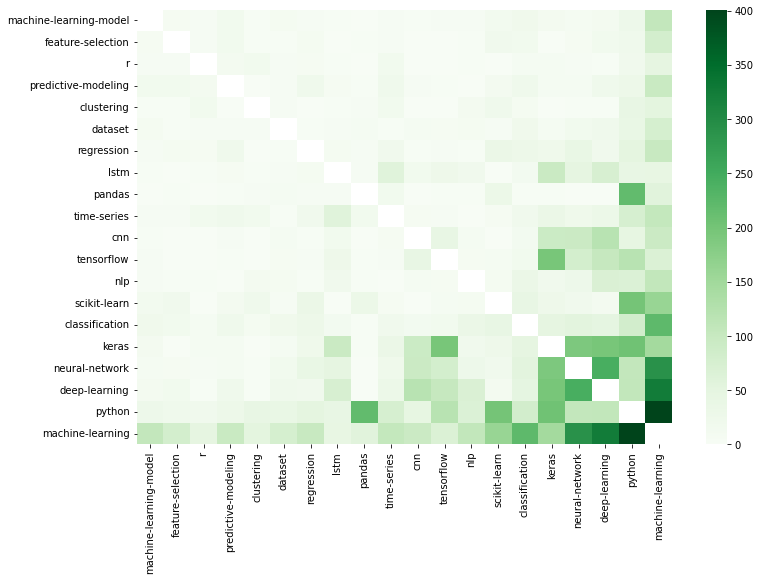

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap = 'Greens', annot = False)

The most used tags also seem to have the strongest relationships, as given by the dark concentrationin in the bottom right corner.However, this could simply be beacuse each of these tags is used a lot, and so end up being used together a lot without possibly eben having any strong relation between them.

A more intuitive manifestation of this phenomenon is the following. A lot of people buy bread, alot of people buy toilet paper, so they end up being purchased together a lot, but purchasing one of them doesn't increase the chance of purchasing the other.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple gorups of tags. For example, it could be the case that when used together, `dataset` and `scikit-learn` have a "strong" relation to `pandas`, nut each by itself doesn't.

So how do we attack this problems? There is a powerful mining techinque that allows us to handle this: association rules. Association rules allows us to analytically spot relations like "people who purchase milk, also purchase eggs".Moreover, we can also measure how strong this relations are on several fronts: how common the relation it is, and how independent the components of the relationship are (toilet paper and bread are probably are more independent than eggs and milk)in the next step).
We won't get into the details of it, as the techinque is out of scope for this course, but it is a path worth investigating!

## Enter Domain Knowlege ##

Keras, scikit-learn, TensorFlow are all python libraries that allow their users to employ deep learning (a type of neural network).

Most of th top tags are all intimately related with one central machine learning theme: deep learning. If we want to be very specific, we can suggest the creation of Python content that uses deep learning for classification problems(and other variations of this suggestion).

At a glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.

## Just a Fad? ##

Let's read in the file into a dataframe called `all_q`. We'll parse the dates at read_time.

In [21]:
all_q = pd.read_csv("/Users/jay/Documents/all_questions.csv", parse_dates = ['CreationDate'])
all_q

,Id,CreationDate,Tags
0,82833,2020-10-10 15:46:16,<image-segmentation><annotation><semantic-segm...
1,82842,2020-10-10 20:37:24,<machine-learning><statistics><data-science-mo...
2,82845,2020-10-10 22:29:21,<python><similarity><fuzzy-logic>
3,82846,2020-10-10 22:37:49,<machine-learning><reinforcement-learning><q-l...
4,82847,2020-10-11 00:15:25,<neural-network><deep-learning><clustering><al...
...,...,...,...
33901,112898,2022-07-23 12:27:12,<classification><smote><pipelines>
33902,112899,2022-07-23 12:48:44,<python><decision-trees><binary-classification>
33903,112900,2022-07-23 12:58:34,<nlp><clustering><predictive-modeling><predict...
33904,112904,2022-07-23 13:42:36,<pandas><statistics><data-science-model><numpy...


We can use the same techinque as before to clean the `Tags` column.

In [22]:
all_q['Tags'] = all_q['Tags'].str.replace("^<|>$", "").str.split("><")

/var/folders/b3/lhqcwxhj01zg5g8dk4qjg3bw0000gn/T/ipykernel_3555/1719054573.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  all_q['Tags'] = all_q['Tags'].str.replace("^<|>$", "").str.split("><")


Before deciding which questions should be classified as being deep learning questions, we should decide what tags belong to deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list `['lstm', 'cnn', 'scikit-learn', 'tensorflow', 'keras', 'neural-network', 'deep-learning']`.

The list was obtained by looking at all the tags in `most_used` and seeing which ones had any relation to deep learning.

We'll now. create a function that assigns `1` to deep learning questions and `0` otherwise; and we use it.

In [23]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
        return 0

In [24]:
all_q['DeepLearning'] = all_q['Tags'].apply(class_deep_learning) 

In [25]:
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning
13209,13341,2016-08-09 21:09:48,"[machine-learning, linear-regression]",0
18342,44391,2019-01-22 18:45:21,"[python, keras, convolutional-neural-network]",0
9215,65359,2019-12-24 01:25:34,"[deep-learning, training, prediction]",1
19275,102194,2021-09-18 01:51:29,"[machine-learning, deep-learning, neural-netwo...",0
29369,81775,2020-09-16 05:30:40,"[neural-network, deep-learning, activation-fun...",1


The data-science-technology landscape isn't something as dynamic to merit daily, weekly, or even monthly tracking. Let's track it quarterly.

In [26]:
all_q = all_q[all_q['CreationDate'].dt.year < 2020]
all_q

,Id,CreationDate,Tags,DeepLearning
38,56905,2019-08-04 00:26:07,"[svm, multilabel-classification]",0
39,56910,2019-08-04 06:49:43,"[machine-learning, keras]",0
40,56912,2019-08-04 08:05:33,"[reinforcement-learning, randomized-algorithms]",0
41,56915,2019-08-04 09:25:11,"[data-mining, data-cleaning, outlier]",0
42,56922,2019-08-04 13:35:23,"[neural-network, loss-function, annotation]",1
...,...,...,...,...
33772,56878,2019-08-03 07:12:27,"[machine-learning, keras]",0
33773,56885,2019-08-03 11:26:24,"[cnn, batch-normalization]",1
33774,56889,2019-08-03 12:05:21,"[deep-learning, keras, manifold]",1
33775,56893,2019-08-03 14:31:31,"[machine-learning, regression, feature-selecti...",0


Let's create a column that identifies the quarter in which a question was asked.

In [27]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(fetch_quarter)

/var/folders/b3/lhqcwxhj01zg5g8dk4qjg3bw0000gn/T/ipykernel_3555/1953586938.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_q["Quarter"] = all_q["CreationDate"].apply(fetch_quarter)


In [28]:
all_q.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
38,56905,2019-08-04 00:26:07,"[svm, multilabel-classification]",0,19Q3
39,56910,2019-08-04 06:49:43,"[machine-learning, keras]",0,19Q3
40,56912,2019-08-04 08:05:33,"[reinforcement-learning, randomized-algorithms]",0,19Q3
41,56915,2019-08-04 09:25:11,"[data-mining, data-cleaning, outlier]",0,19Q3
42,56922,2019-08-04 13:35:23,"[neural-network, loss-function, annotation]",1,19Q3


For the final stretch of the screen, we'll group by quarter end:

- Count the number of deep learning questions.
- Count the total number of questions.
- Computer the ratio between the two numbers above.

In [29]:
quarterly = all_q.groupby('Quarter').agg({'DeepLearning': ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly['DeepLearningRate'] = quarterly['DeepLearningQuestions'] / quarterly['TotalQuestions']
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
0,14Q2,3,157,0.019108
1,14Q3,4,188,0.021277
2,14Q4,4,214,0.018692
3,15Q1,5,188,0.026596
4,15Q2,6,284,0.021127
5,15Q3,13,310,0.041935
6,15Q4,19,379,0.050132
7,16Q1,39,510,0.076471
8,16Q2,46,510,0.090196
9,16Q3,71,575,0.123478


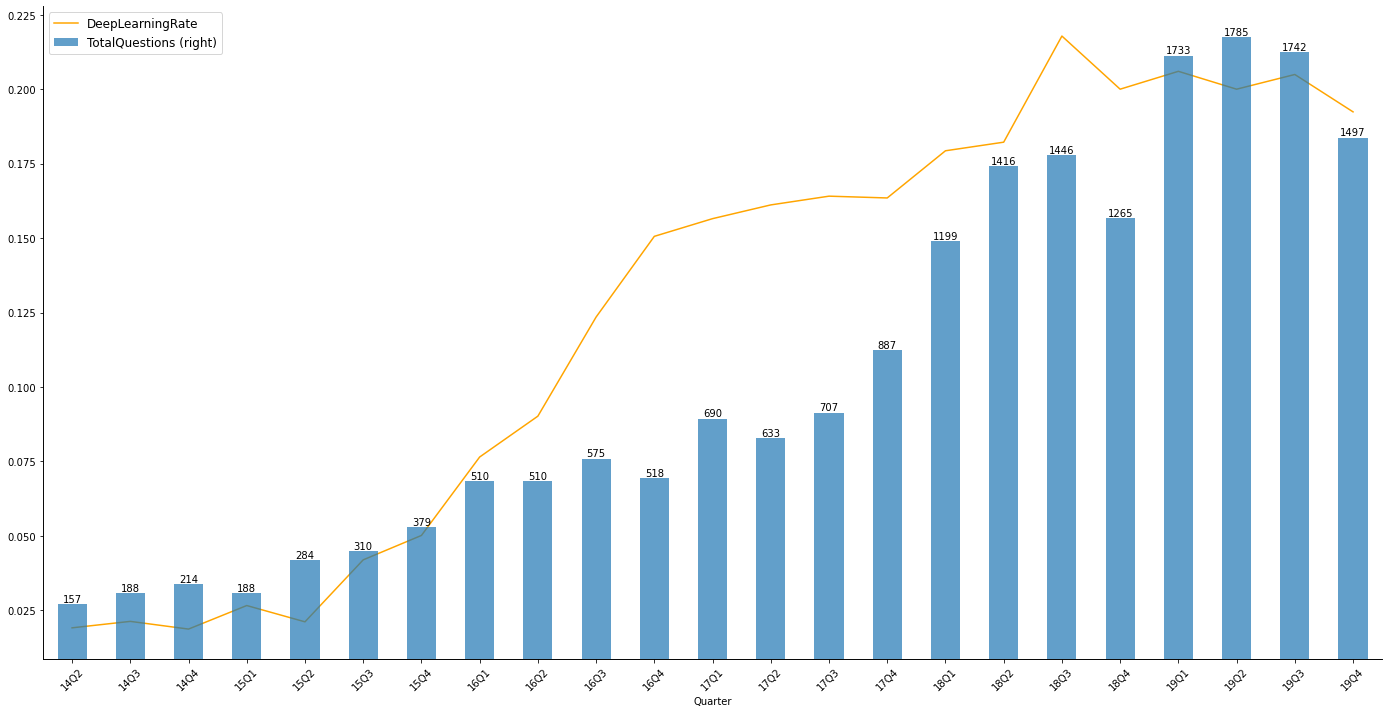

In [30]:
ax1 = quarterly.plot(x = 'Quarter', y = 'DeepLearningRate', kind = 'line', linestyle = '-', color = 'orange',
                     figsize = (24,12)
                    )

ax2 = quarterly.plot(x = 'Quarter', y = 'TotalQuestions', kind = 'bar', ax = ax1, secondary_y = True, alpha = 0.7,
                     rot = 45)

for idx, t in quarterly['TotalQuestions'].iteritems():
    ax2.text(idx, t, str(t), ha = 'center', va = 'bottom')
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles = handles1 + handles2,
           labels = labels1 + labels2,
           loc = 'upper left', prop = {'size': 12})

for ax in (ax1, ax2):
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
        ax.tick_params(right = False, labelright = False)

It seems that deep learning questions was a high-gowth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.